### HW RFM analysis
В каждом подсегменте пользователи поделены на 4 класса. Отсчитано количество дней, прошедших с момента последней покупки, с максимальной даты покупки в датасете.
Найдены ответы на следующие вопросы:
- Какое максимальное кол-во покупок было совершено одним пользователем?
- Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?
- Сколько пользователей попало в сегмент 111?
- Сколько пользователей попало в сегмент 311?
- В каком RFM-сегменте самое большое кол-во пользователей?
- В каком RFM-сегменте самое маленькое кол-во пользователей?

In [1]:
import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")
# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
 orders = pd.read_csv('RFM_ht_data (1).csv',sep=',', parse_dates=[2])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
# Произведем первичный анализ данных
orders.head() 

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [4]:
orders.shape[0]

332730

In [29]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [31]:
# Приводим данные в нужный формат
orders['InvoiceNo'] = orders['InvoiceNo'].apply(str)
orders['CustomerCode'] = orders['CustomerCode'].apply(str)

In [36]:
orders.describe(include='all', datetime_is_numeric=True)

,InvoiceNo,CustomerCode,InvoiceDate,Amount
count,332730,332730,332730,332730.000000
unique,332730,123733,NaN,NaN
top,D0711810300537,19057820,NaN,NaN
freq,1,204,NaN,NaN
mean,NaN,NaN,2020-09-15 16:35:03.846361856,1239.029737
min,NaN,NaN,2020-09-01 00:00:00,-8925.000000
25%,NaN,NaN,2020-09-08 00:00:00,350.000000
50%,NaN,NaN,2020-09-16 00:00:00,720.445000
75%,NaN,NaN,2020-09-24 00:00:00,1491.507500
max,NaN,NaN,2020-09-30 00:00:00,131874.000000


### RFM анализ

In [35]:
last_date = orders['InvoiceDate'].max() # найдем дату последнего заказа

In [34]:
last_date

Timestamp('2020-09-30 00:00:00')

Создадим дата фрейм с данными по каждому пользователю: количеством дней с последнего заказа, количеством заказов, общей суммой по всем заказам.

In [37]:
rfmTable = orders.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'InvoiceNo': 'count',      # Frequency #Количество заказов
                                        'Amount': 'sum'}) # Monetary Value #Общая сумма по всем заказам
# Переименуем колонки
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)


In [38]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88


Разделим пользователей по классам от 1 до 4, 1 класс - самые выгодные пользователи.

In [13]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [14]:
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [15]:
rfmSegmentation = rfmTable

In [16]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [17]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) + rfmSegmentation.F_Quartile.map(str) + rfmSegmentation.M_Quartile.map(str)

In [18]:
rfmSegmentation.head() 

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443


In [42]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


In [43]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)

Построим табличку с классами по значениям recency, frequency, а в ячейках - медианное значение LTV в сегменте.

In [44]:
rfm_table.head()

F_Quartile,1,2,3,4
R_Quartile,,,,
1,5768,2733,1805,729
2,4947,2895,1868,814
3,4179,2770,1813,773
4,3822,2682,1813,859


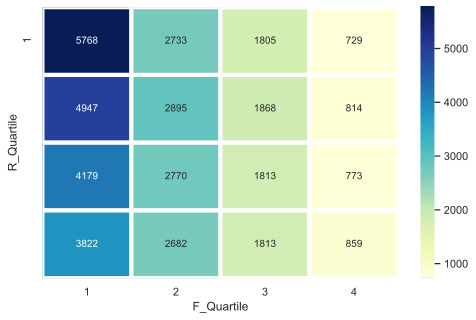

In [45]:
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

Ответим на вопросы.

- Какое максимальное кол-во покупок было совершено одним пользователем?

In [41]:
orders.groupby('CustomerCode').agg({'InvoiceNo':'count'}).InvoiceNo.max()

204

- Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?

In [19]:
rfmSegmentation.query('F_Quartile == 1').groupby('F_Quartile').agg({'frequency':'min'})

,frequency
F_Quartile,
1,4


- Сколько пользователей попало в сегмент 111?

In [20]:
rfmSegmentation.query('RFMClass == "111"').shape[0]

9705

- Сколько пользователей попало в сегмент 311?

In [21]:
rfmSegmentation.query('RFMClass == "311"').shape[0]

1609

- В каком RFM-сегменте самое большое кол-во пользователей?

In [22]:
rfmSegmentation.groupby('RFMClass').agg({'monetary_value':'count'}).sort_values(by='monetary_value',ascending=False).head()

,monetary_value
RFMClass,
444,10624
111,9705
443,6729
344,6593
211,5847


В классе 444.

- В каком RFM-сегменте самое маленькое кол-во пользователей?

In [23]:
rfmSegmentation.groupby('RFMClass').agg({'monetary_value':'count'}).sort_values(by='monetary_value',ascending=True).head()

,monetary_value
RFMClass,
414,2
314,33
114,60
214,60
424,63


В классе 414